In [542]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D 
from matplotlib import cm
import matplotlib as mpl
from scipy.interpolate import griddata
from tqdm import tqdm
%matplotlib inline

# Potential
We consider the non singular isothermal ellipsoid
$$
    \psi(\theta_1, \theta_2) = \sqrt{\theta_1^2 + 2\theta_2^2 + 0.1}
$$
The perturbed potential will be rotated clockwise by $1^\circ$. 

The elements of the magnification matrix inverse for a spherical potential are
$$
    A^{-1}_{ij} \equiv \frac{\partial \vec{\beta}}{\partial \vec{\theta}} = \delta_{ij} -  \frac{\partial^2 \psi}{\partial \theta_i \partial \theta_j} = \delta_{ij} - \left(\frac{\delta_{ij} \psi^2 - \theta_i \theta_j}{\psi^3} \right)
$$

The critical curves are defined such that the inverse of the magnification $\mathcal{M}^{-1} = \det(A^{-1})$ is zero (leading to infinite magnification).

The time delay is given by
$$
    T(\vec{\theta}) = \frac{1}{2}(\vec{\theta} - \vec{\beta})^2 - \psi(\vec{\theta})
$$
where $\beta$ is the source coordinate frame given by
$$
    \vec{\beta}({\vec{\theta}}) = \vec{\theta} - \vec{\alpha}(\vec{\theta})
$$
$\alpha$ are deflection angles which are just
$$
    \vec{\alpha} = \vec{\nabla}\psi(\vec{\theta})
$$

In [461]:
a = 2
x_c = 0.1
def psi(theta1, theta2):
    return np.sqrt(theta1**2 + a*theta2**2 + x_c)

def grad_psi(theta1, theta2):
    p = psi(theta1, theta2)
    grad1 = theta1 / p
    grad2 = a * theta2 / p
    return grad1, grad2

def psi_11(theta1, theta2):
    p = psi(theta1, theta2)
    return (a * theta2**2 + x_c)/p**3

def psi_22(theta1, theta2):
    p = psi(theta1, theta2)
    return (a * p**2 - a**2 * theta2**2)/p**3

def psi_12(theta1, theta2):
    return - theta1 * a * theta2 / psi(theta1, theta2)**3

def rotate(theta1, theta2, phi):
    rho = np.hypot(theta1, theta2)
    varphi = np.angle(theta1 + 1j*theta2) - phi
    rotated_theta1 = rho * np.cos(varphi)
    rotated_theta2 = rho * np.sin(varphi)
    return rotated_theta1, rotated_theta2

def inverse_mag_det(theta1, theta2):
    return (1 - psi_11(theta1, theta2)) * (1 - psi_22(theta1, theta2)) - psi_12(theta1, theta2)**2

def time_delay(theta1, theta2, x=0, y=0):
    return 0.5 * np.dot(theta1 - x, theta2 - y) - psi(theta1, theta2)
    

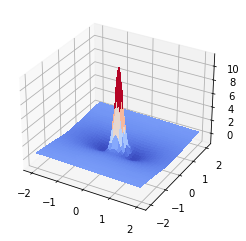

In [462]:
# image plane
N = 201
phi = np.deg2rad(1.1)

theta = np.linspace(-2, 2, N)
theta_x, theta_y = np.meshgrid(theta, theta)
theta_x, theta_y = rotate(theta_x, theta_y, phi)

fig = plt.figure()
ax = fig.gca(projection='3d')
surf = ax.plot_surface(theta_x, theta_y, inverse_mag_det(theta_x, theta_y), cmap=cm.coolwarm,
                       linewidth=0, antialiased=False)

(-2.0380263090426682,
 2.0380263090426682,
 -2.038026309042668,
 2.0380263090426687)

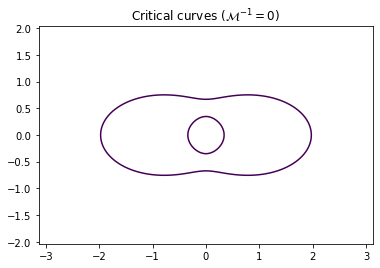

In [463]:
contour = plt.contour(theta_x, theta_y, inverse_mag_det(theta_x, theta_y), [0])
plt.title(r"Critical curves ($\mathcal{M}^{-1} = 0$)")
plt.axis("equal")

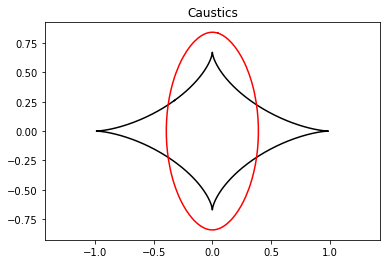

In [464]:
alpha_x, alpha_y = grad_psi(theta_x, theta_y)
critical_curve1 = contour.collections[0].get_paths()[0].vertices
critical_curve2 = contour.collections[0].get_paths()[1].vertices

cc11 = critical_curve1[:, 0]
cc12 = critical_curve1[:, 1]
thetas = np.column_stack([theta_x.ravel(), theta_y.ravel()])
alpha1_cc = griddata(thetas, alpha_x.ravel(), (cc11, cc12), method="cubic")
alpha2_cc = griddata(thetas, alpha_y.ravel(), (cc11, cc12), method="cubic")
caustic1_x = cc11 - alpha1_cc
caustic1_y = cc12 - alpha2_cc

cc21 = critical_curve2[:, 0]
cc22 = critical_curve2[:, 1]
thetas = np.column_stack([theta_x.ravel(), theta_y.ravel()])
alpha1_cc = griddata(thetas, alpha_x.ravel(), (cc21, cc22), method="cubic")
alpha2_cc = griddata(thetas, alpha_y.ravel(), (cc21, cc22), method="cubic")

caustic2_x = cc21 - alpha1_cc
caustic2_y = cc22 - alpha2_cc
# plt.plot(cc11, cc12, "k--", label="Critical curve 1")
# plt.plot(cc21, cc22, "r--", label="Critical curve 2")
plt.plot(caustic1_x, caustic1_y, "k-", label="Caustic 1")
plt.plot(caustic2_x, caustic2_y, "r-", label="Caustic 2")
# plt.legend()
plt.title("Caustics")
plt.axis("equal");

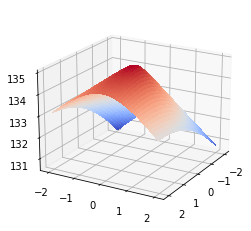

In [466]:
fig = plt.figure()
ax = fig.gca(projection='3d')
surf = ax.plot_surface(theta_x, theta_y, time_delay(theta_x, theta_y, x=0.3), cmap=cm.coolwarm,
                       linewidth=0, antialiased=False)
ax.view_init(20, 30)

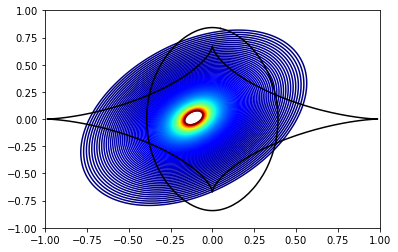

In [606]:
# make an elliptical source
beta1_0 = 0.1
beta2_0 = 0.05
elp = 0.634
phi = np.deg2rad(147.2)
beta_c = 2
I = 100
def source(beta1, beta2):
    beta1, beta2 = rotate(beta1, beta2, phi)
    return np.sqrt(beta_c) / np.hypot(beta1 - beta1_0, elp*(beta2 - beta2_0))

beta = np.linspace(-1, 1, N)
b1, b2 = np.meshgrid(beta, beta)
s = source(b1, b2)
M = 100
norm = mpl.colors.Normalize(vmin=0.,vmax=M)
cmap= cm.get_cmap("jet")
source_contours = plt.contour(b1, b2, s, levels=np.logspace(0.4, 1.5, M), cmap=cmap, linestyles="-")
plt.plot(caustic1_x, caustic1_y, "k-", label="Caustic 1")
plt.plot(caustic2_x, caustic2_y, "k-", label="Caustic 2")

100%|██████████| 100/100 [00:01<00:00, 52.16it/s]


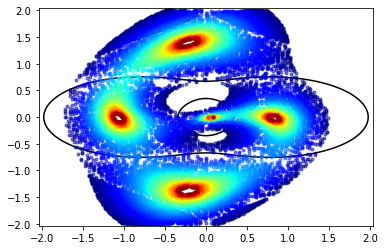

In [607]:
def betas_to_thetas(curve, alpha_x, alpha_y):
    c1 = curve[:, 0] # curve in beta space
    c2 = curve[:, 1]
    alphas = np.column_stack([alpha_x.ravel(), alpha_y.ravel()])
    betas = thetas - alphas # lens equation
    new_curve1 = griddata(betas, theta_x.ravel(), (c1, c2), method="nearest") # map from beta to theta
    new_curve2 = griddata(betas, theta_y.ravel(), (c1, c2), method="nearest")
    return new_curve1, new_curve2


for i, curve in enumerate(tqdm(source_contours.collections)):
    c = curve.get_paths()[0].vertices
    nc1, nc2 = betas_to_thetas(c, alpha_x, alpha_y)
    plt.plot(nc1, nc2, ".", color=cmap(norm(i)), alpha=0.5)
contour = plt.contour(theta_x, theta_y, inverse_mag_det(theta_x, theta_y), [0], colors="k")


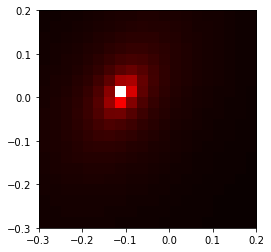

In [718]:
beta, h = np.linspace(-.3, .2, 20, retstep=True)
b1, b2 = np.meshgrid(beta, beta)
s = source(b1, b2)
I = source(b1, b2)
I /= I.sum()#normalize
I_grad_x, I_grad_y = np.gradient(I)
I_grad_x /= 2 * h
I_grad_y /= 2 * h
extent = [beta.min(), beta.max(), beta.min(), beta.max()]
plt.imshow(I, extent=extent, cmap="hot", origin="lower")

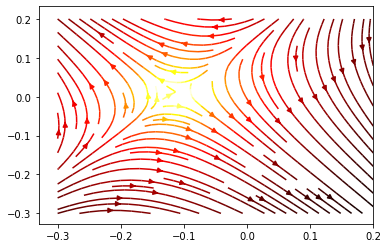

In [719]:
color = np.log(np.hypot(I_grad_x, I_grad_y))
norm = mpl.colors.Normalize(vmin=color.min(),vmax=color.max())
cmap = cm.get_cmap("hot")
grad_stream = plt.streamplot(b1, b2, I_grad_x, I_grad_y, density=1, color=color, cmap=cmap)